# TIME SERIES ANALYSIS

# Goal: Find outliers, trends and periodicity in the MTA turnstyle data
    

## DATA:
MTA subway fares. It is a complete dataset of
rides logged by card swipes for 600 Manhattan stations.

The data was organized  by Sina Kashuk at CUSP.

It contains 23 different subway card types 
(e.g. monthly pass, daily pass, Act for Disability pass…) as follows:


# Task 1: 
## Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series.
## Identify it and figure out what it is due to.


# Task 2: 
## Some of the time series are stationary, some have a complex structure, some show a downward trend: Identify the **ridership types**  that have steadily increased in popularity,  and that have steadily decreased. by how much? (e.g what is the ratio of usage in the first 10 and last 10 weeks)


# Task 3: 
## Build a classifier that assigns a card type to a time series based on time series features


Populating the interactive namespace from numpy and matplotlib


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['mean', 'std', 'clf']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


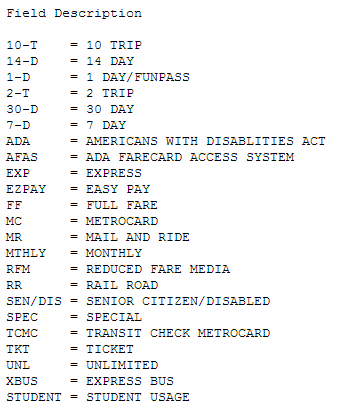

In [104]:
from __future__ import print_function, division
import pylab as pl
import numpy as np
import pandas as pd

from sklearn.ensemble  import RandomForestClassifier as rfc
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import statsmodels.api as sm

%pylab inline
from itertools import cycle
from IPython.display import Image
from IPython.display import clear_output
pl.rcParams['font.size'] = 20
Image(filename = "Ridetypes.png")


This is the information I recieved about the data: "each time series (per station, per ticket type) contains
the number of swipes per week for 194 weeks 
from 05/19/2010 to 02/19/2014. "

The data are available to you as a python data cube here:

you can load it as 

np.load(“MTA_Fare.npy") and 


you will end up with a python numpy array of 
shape (600,23,194)

** note that the missing values are inputted as -1**

if you want to do things like algebra (summing time series for example) you need to take care of that! if you replace the -1 entries with NaN remember to use functions that can deal with nans:
np.nanmean
np.nansum...

# HINTS: 

## notes and hints: 

   1) you could coerce the data into a pandas dataframe, but the data is truly a "datacube": a 3D dataset, and flattening it into a pandas dataframe will make it far more difficult to manipulate. I strongly recommand you keep it as a numpy array
    
   2) note that the missing values are inputted as -1. if you want to do things like algebra (summing time series for example) you need to take care of that. If you replace the -1 entries with NaN, you may need to use functions that explicitly know how to deal with NaN: for example, to sum use the np.nansum etc
```
np.nanmean(mtarides)
np.nansum(mtarides)
```
as opposed to just 
```
np.mean(mtarides)
np.sum(mtarides)
```
 
## There are 600 stations, 23 card types. The trick to do this homework succesfully is to "collaps" (by averaging, or summing, depending on the question) the appropriate dimension in different parts of the homework: when you need to work at the station level (if I ask "which station is the one that..."), collaps the card type, when you need to work on the card type, collapse the stations. 

When I ask you "which station ...", you can sum or average over the ridership types for all station and reduce your data by a factor 23. When I ask you "which rideship type ..." you can sum or average over the stations and reduce your data by a factor 600! (or even better you could take a weighted average - *np.average(....weight=...)* -. The sum and average functions take an *axis* argument, which allows you to control which axis of the cube gets averaged. The dimension of the resulting object will allow you to check that you averaged over the right axis.


# Possibly useful functions

You are already familiar with and have already used  most of the functions I needed to perform this exercise. Here are some reminders and on few functions and methods that you may not have encountered yet which may be useful. You do not have to use them: there are many ways to do things and you do not have to solve this problem like I did, but here they are in case you need some help:

* the numpy function np.where() returns the index where a condition is true. It is slow and inefficient but very intuitive and convenient


* the nupy functions np.nansum(), np.sum(), np.nanmean() etc take an array and the axis along which to sum as inputs. If you want to sum over stations, or over rides, you can use these passing the appropriate axis number: axis=1 axis=2...


*  the array methods 
```
np.array.flatten()
np.array.reshape()
```
     allow you to manipulate the shape of an array, for example if you want to run analysis on each individual time series, each station and each ridership type, which I recommand if you want to work on clustering for extra credit (resulting into 600*23=13800 time series) you can flatten the array as
     
```
mtaarray.flatten()
```

    which returns the flatten array:

```
mtaRides = np.load("MTA_Fare.npy")

mtaRides.shape
Out[10]: (600, 23, 194)

mtaRides.flatten().shape
Out[11]: (2677200,)
````

# read in data as instructed above

In [2]:
# Loading Data
mta = np.load("MTA_Fare.npy")
mta.shape

(600, 23, 194)

In [3]:
print ("MTA array shape:", mta.shape)
print ("MTA array shape summed over all ride types:", np.nansum(mta,axis=1).shape)

MTA array shape: (600, 23, 194)
MTA array shape summed over all ride types: (600, 194)


create a "ride types" list based on the metadata I was given

In [4]:
#ridership type list
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])
print("number of ride types", len(ridetype))

number of ride types 23


You need to create a date range to plot properly. 
After that I create a date range (for example with pd.date_range())
in a log plot to enhance the visibility along the y axis (np.log10(weightedrides[i]))
all time series, each station each ride type, look like this (pretty ugly)

In [5]:
# plot the data in natural space
# then plot the  data in log space (may take a while to plot because of the very inefficient double for loop - 
# the counter needs to get to 23)
#mta=mta.astype(float)
# reshape the array
Rides_n=mta.reshape(13800, 194)
# sum up the array
Rides = np.nansum(mta,axis=1)
Rides.shape

(600, 194)

In [6]:
Rides_type = np.nansum(mta,axis=0)
Rides_type.shape

(23, 194)

In [7]:
Rides_pd=pd.DataFrame(Rides)
Rides_pd.head()

0       1       2       3       4       5       6       7       8    \
0  126877  149476  152382  160174  162640  156413  159155  159373  163284   
1   37305   46463   49358   44848   41508   35653   41988   41908   41213   
2    6605    6880    7228    5730    7031    5106    5496    5667    5554   
3   16377   17407   17594   14241   17588   13167   14509   14387   14220   
4   18563   19902   19947   16075   20282   14600   16150   16065   16204   

      9    ...      184    185    186    187    188    189    190    191  \
0  159251  ...    87973  83825  91001  80908  79891  69881  79550  78901   
1   41141  ...      -23    -23    -23    -23    -23    -23    -23    -23   
2    6941  ...     8268   5928   5656   7665   8377   7343   7743   8171   
3   17179  ...    23450  16228  15586  21806  23534  20604  21370  22459   
4   19618  ...    23025  18253  17293  21484  22516  20560  21942  23283   

     192    193  
0  74591  76833  
1    -23    -23  
2   7907   6790  
3  22773  19033  
4  22987  21562  

[5 rows x 194 columns]

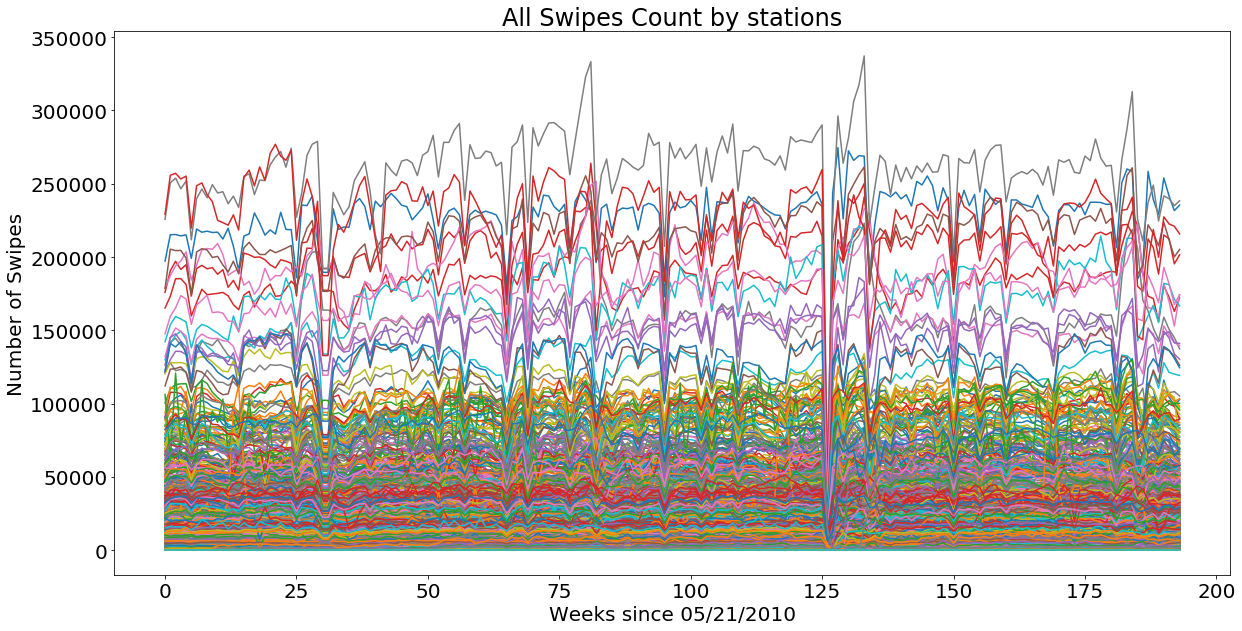

In [8]:
pl.figure(figsize=(20,10))
pl.plot(Rides_n.T)
pl.title("All Swipes Count by stations")
pl.xlabel("Weeks since 05/21/2010")
pl.ylabel("Number of Swipes")

### Figure 1:
time series for all ride types and at all stations.

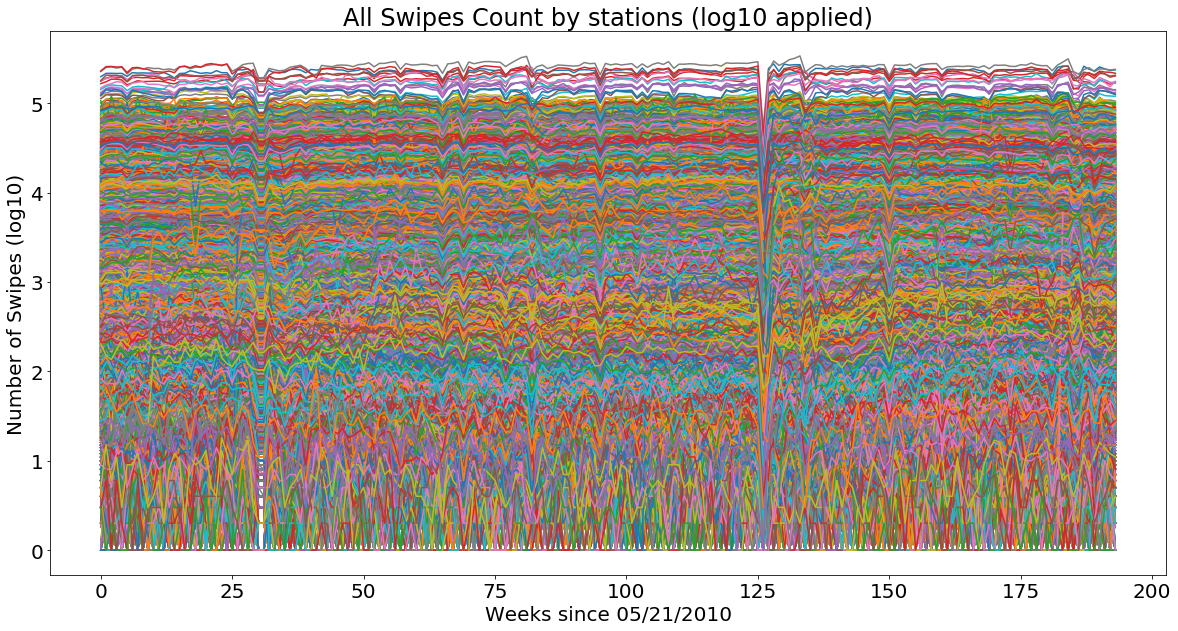

In [9]:
pl.figure(figsize=(20,10))
# pl.plot(np.log10(Rides))
# Needs to transpose the array to make x the week count
# pl.plot(np.log10(Rides_n))
pl.plot(np.log10(Rides_n).T)
pl.title("All Swipes Count by stations (log10 applied)")
pl.xlabel("Weeks since 05/21/2010")
pl.ylabel("Number of Swipes (log10)")

### Figure 2: 
time series for all ride types and all stations in semi-log space

# 1: event detection 

## Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series. Find the date and see what  may have caused this event 



In [10]:
ride_w = np.nansum(Rides,axis=0)
ride_w.shape

(194,)

In [11]:
ride_std = (np.log10(ride_w)).std()
ride_mean = (np.log10(ride_w)).mean()
print('Std:',ride_std,"Mean:", ride_mean, '\n3 Sigma Upper Bound:',ride_mean + 3*ride_std, 
      '\n3 Sigma Lower Bound:',ride_mean - 3*ride_std)

Std: 0.0653227855375 Mean: 7.4703541445 
3 Sigma Upper Bound: 7.66632250111 
3 Sigma Lower Bound: 7.27438578789


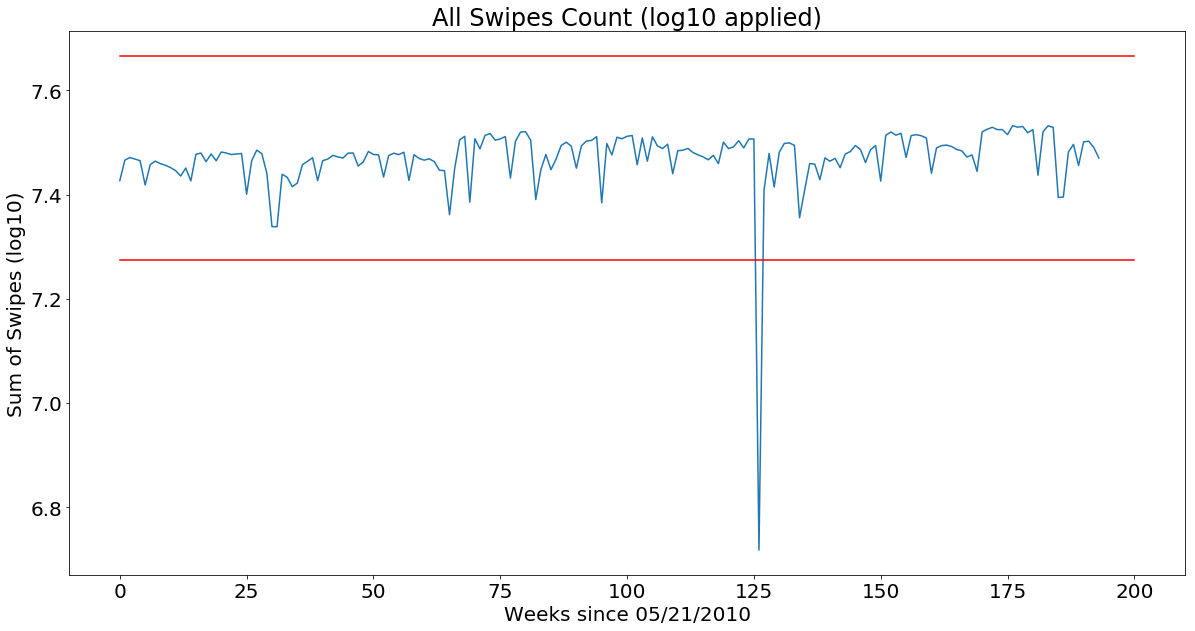

In [12]:
pl.figure(figsize=(20,10))
# pl.plot(np.log10(Rides))
# Needs to transpose the array to make x the week count
# pl.plot(np.log10(Rides_n))
pl.plot(np.log10(ride_w).T)
sigma_l = ride_mean - 3*ride_std
sigma_u = ride_mean + 3*ride_std
pl.plot([0, 200], [sigma_l, sigma_l], "k", c='r')
pl.plot([0, 200], [sigma_u, sigma_u], "k", c='r')
pl.title("All Swipes Count (log10 applied)")
pl.xlabel("Weeks since 05/21/2010")
pl.ylabel("Sum of Swipes (log10)")

## Figure 3:
From the figure above, there are regular flucturations. Most of the time, the fluctuations are within the magnitude range of 7.3 to 7.5. However, we can see that there is a very significant drop around week 125 (magnitude level around 6.7). 

In [13]:
# The drop that outside the three sigma boundary is around week 125. Let's find out which one it is
x = np.where(np.log10(ride_w)<7)
x

(array([126]),)

## Result:

Week 126 since 05/21/2010 is around the week following 10/26/2012. During that time, hurricane Sandy visited New York City. The weather cause delays and service suspension of public transit and also many people stayed home.

 # 2: finding trends

## NOTE ON THE TREND DETECTION:
### you should find the *ride type* that has the steepest increase, and the steepest decrease. Notice: we are looking for something that has a more or less constant trend

### to do this you can sum or average (a weighted average is probably best) over all stations, leaving you with 23 time series, one per ridership type. 

### you can use a rolling mean for smoothing (pd.rolling_mean() for example), and you can calculate the ratio of the *number of rides* near the beginning to the *number of rides* near the end of the time series.

### notice that you should inspect the time series, algorithmically or at least by eye, to ensure you see a trend, and not just changing structure. Below is an example of a lightcurve with structure (top) and a lightcurve with a constant trend (bottom) both showing a large deviation between the beginning and the end of the time series


In [14]:
for i in range (23):    
    print(mta[:,i,:].std())

32698.0977317
1607.17007118
123.849685152
467.835953745
384.939782221
10568.2997974
22401.6878905
12.4828490111
488.261158722
671.762532897
134.853958569
390.479682063
185.980563205
821.356019781
1373.23360024
453.295364375
202.020044863
483.21490484
1773.61246566
703.190810215
214.259532782
33.7448499255
1893.46856203


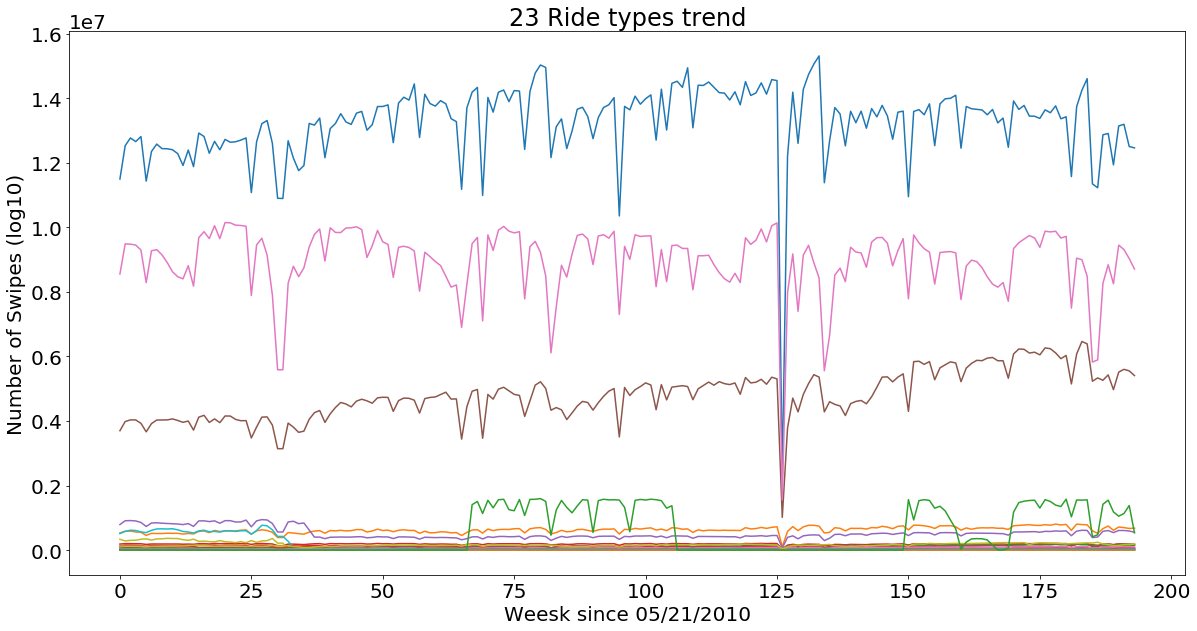

In [15]:
# Plot the trend for all 23 types of rides
pl.figure(figsize=(20,10))
pl.plot(Rides_type.T)
pl.xlabel("Weesk since 05/21/2010")
pl.ylabel('Number of Swipes (log10)')
pl.title('23 Ride types trend')

## Figure 4: 
All rides from 23 different types are plotted. It is hard to determine the trends, especially some with very low swipes are difficult to see.


In [16]:
# There are ways to use numpy to calculate rolling means, however, it is 
# To calculate rolling means, need to turn into pandas df first
ridetype_df = pd.DataFrame(Rides_type, index = ridetype)
ridetype_df.head()

0         1         2         3         4         5         6    \
10t  11494477  12526720  12766490  12653538  12809558  11429646  12346741   
14d    530386    583394    586057    562465    548722    455554    518051   
1d      47663     51347     51499     51926     51017     46715     48827   
2t     186413    199090    199531    196252    194747    175511    188331   
30d     46670     64214     56857     37292     35074     46712     60089   

          7         8         9      ...          184       185       186  \
10t  12576621  12436978  12431120    ...     14603889  11344807  11223293   
14d    513274    512055    522432    ...       781390    596203    518819   
1d      49491     48893     50239    ...        62519     50682     45016   
2t     187952    186685    190391    ...       193129    164469    148515   
30d     47301     31947     52034    ...        56532     22485     25164   

          187       188       189       190       191       192       193  
10t  12864727  12904674  11932832  13139222  13189472  12500619  12459809  
14d    664393    744853    613156    713579    694996    670091    679359  
1d      55991     60292     51526     57070     58633     56388     55054  
2t     177747    193410    168794    189426    184101    179892    179225  
30d     67575     64730     43288     47666     60963     59263     46721  

[5 rows x 194 columns]

In [17]:
ridetype_df.columns

RangeIndex(start=0, stop=194, step=1)

In [18]:
ridetype_df.index

Index([u'10t', u'14d', u'1d', u'2t', u'30d', u'7d', u'ada', u'afas', u'exp',
       u'ez', u'ff', u'mc', u'mr', u'month', u'rfm', u'rr', u'sen', u'spec',
       u'tcmc', u't', u'umlim', u'xbus', u'stud'],
      dtype='object')

In [19]:
# Transpose the df so it's easier to be plotted.
ridetype_dft=ridetype_df.T
ridetype_dft.head()

10t     14d     1d      2t    30d       7d      ada   afas     exp  \
0  11494477  530386  47663  186413  46670  3697305  8551799   9925  333059   
1  12526720  583394  51347  199090  64214  3981669  9486255  11708  282616   
2  12766490  586057  51499  199531  56857  4032893  9476401  12140  301891   
3  12653538  562465  51926  196252  37292  4032616  9449944  11084  305376   
4  12809558  548722  51017  194747  35074  3925310  9293866  10379  335644   

       ez  ...    month     rfm     rr    sen  spec    tcmc      t  umlim  \
0  511894  ...   122996  789972  59671  28083  -138  124555  20922   5990   
1  577884  ...   151809  907929  69070  32194  -139  121574  21531   5981   
2  615400  ...   151401  913987  69437  32481  -137  122044  21296   6353   
3  606133  ...   146957  902412  67962  32267  -137  121914  21493   6453   
4  563310  ...   137752  855437  66241  31797    40  119640  20161   6177   

   xbus  stud  
0   220  -600  
1   335  -600  
2   328  -600  
3   347  -600  
4   316  -600  

[5 rows x 23 columns]

In [20]:
# ridetype_dft['roll_mean'] = ridetype_dft[i].rolling(window=4).mean()

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:9: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=4,center=False).mean()
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python2/lib/python2.7/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


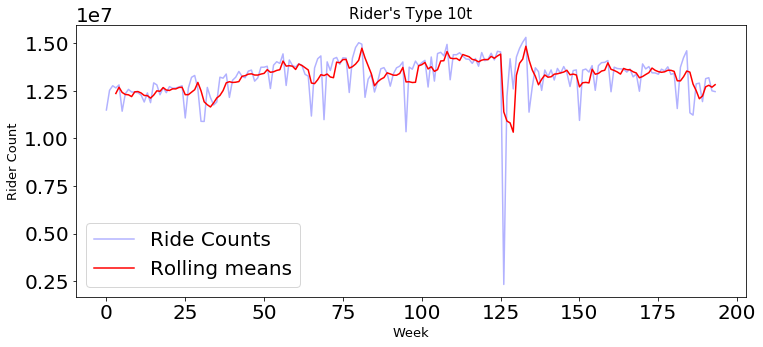

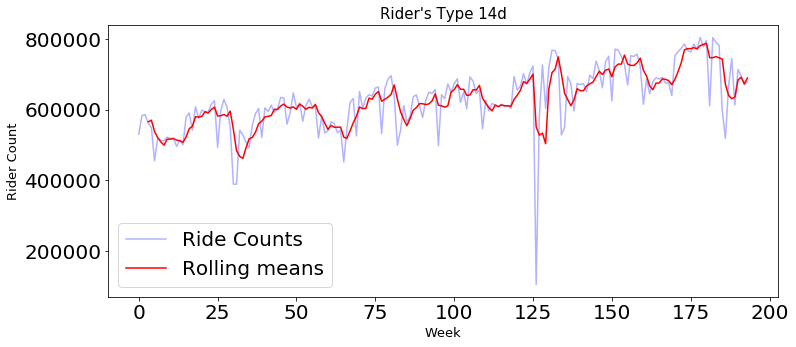

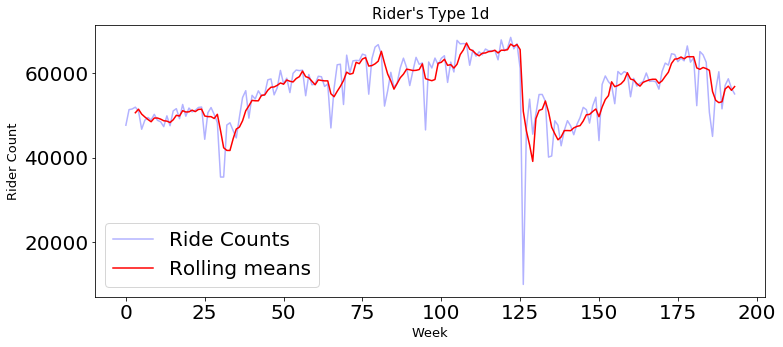

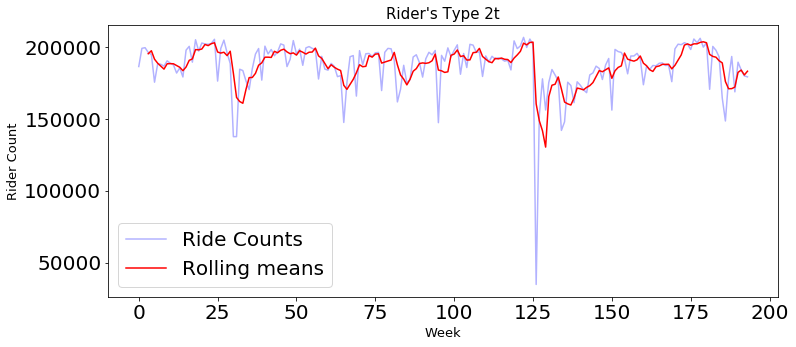

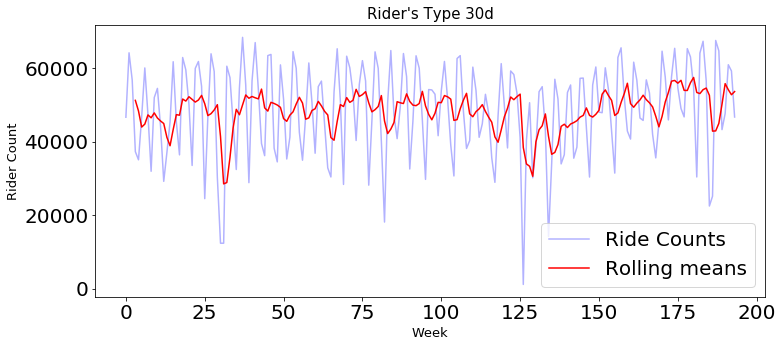

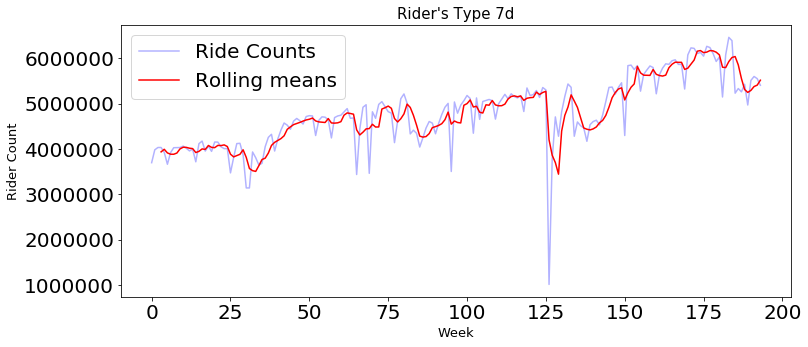

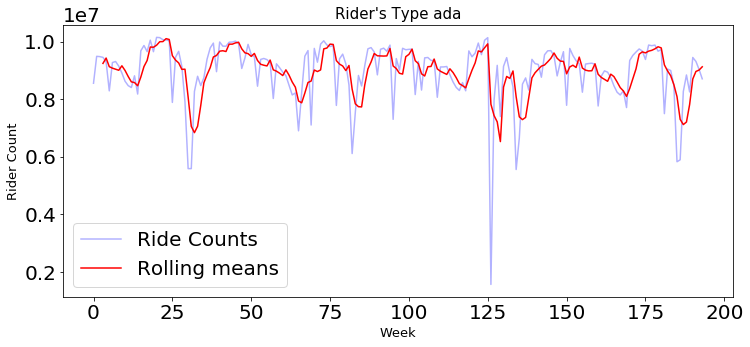

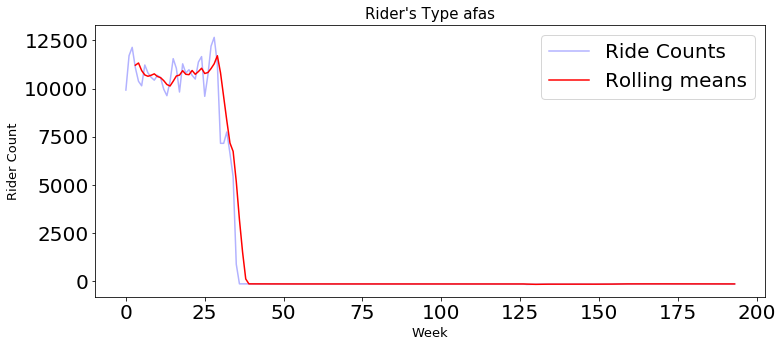

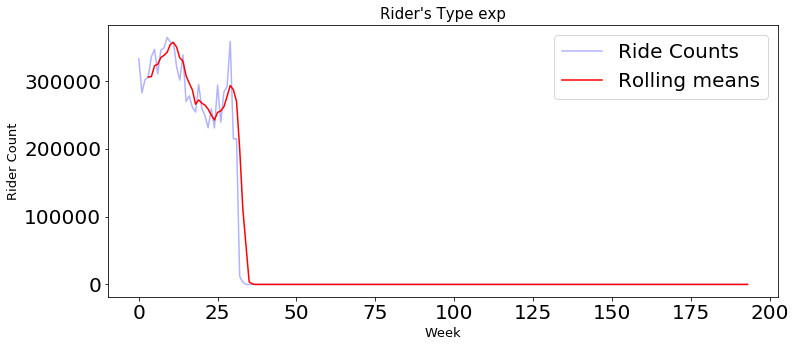

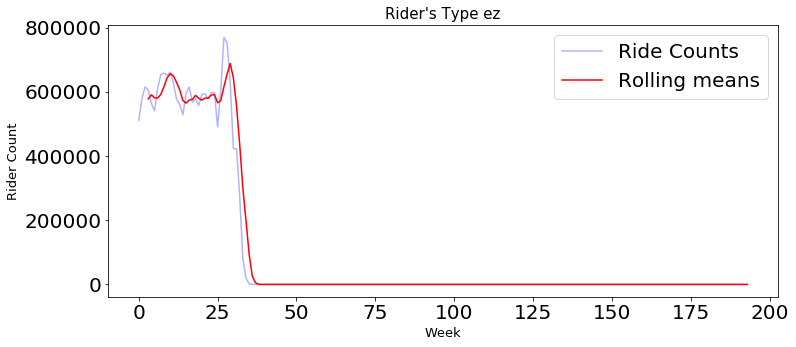

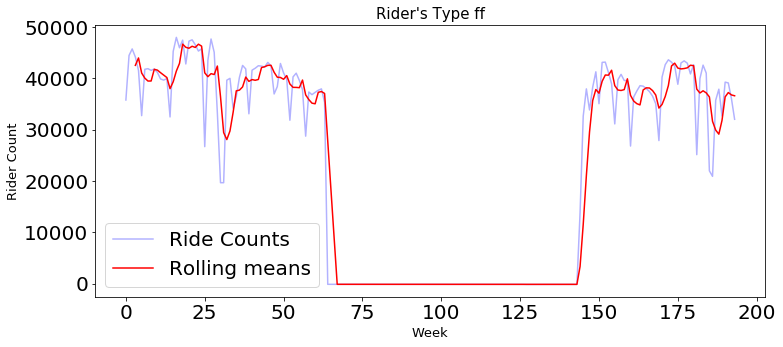

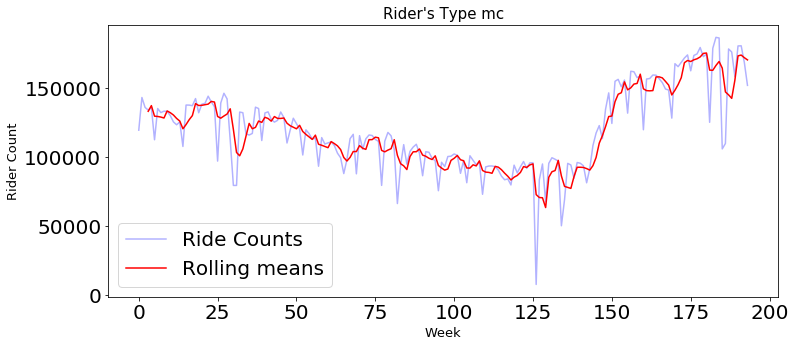

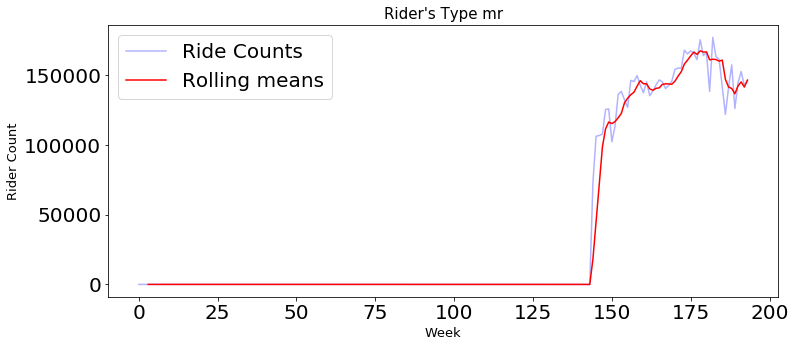

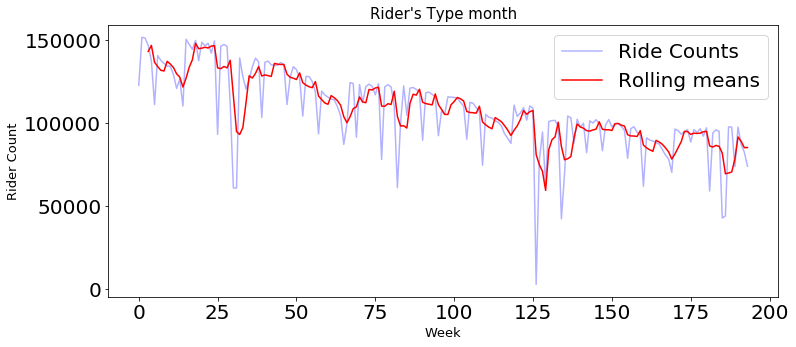

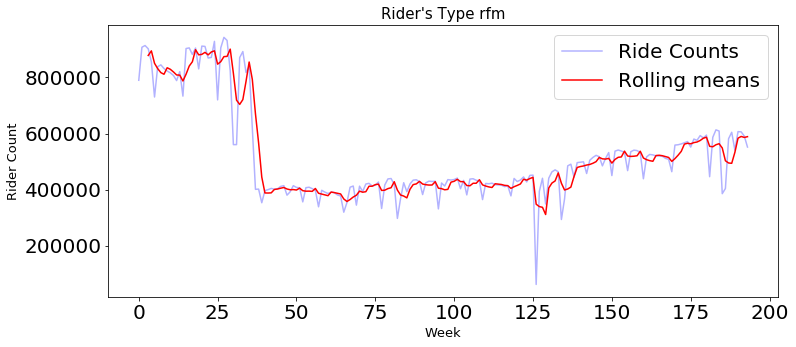

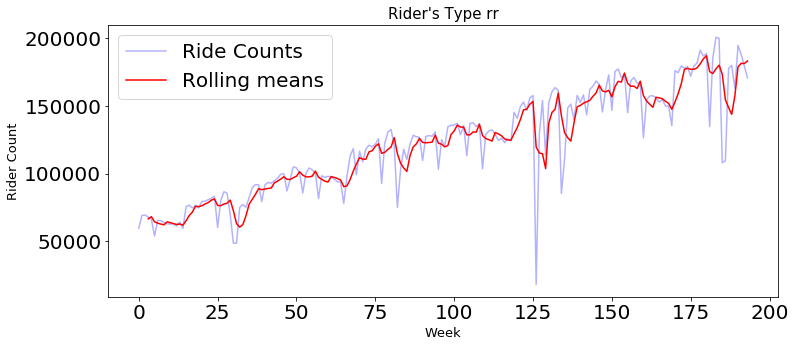

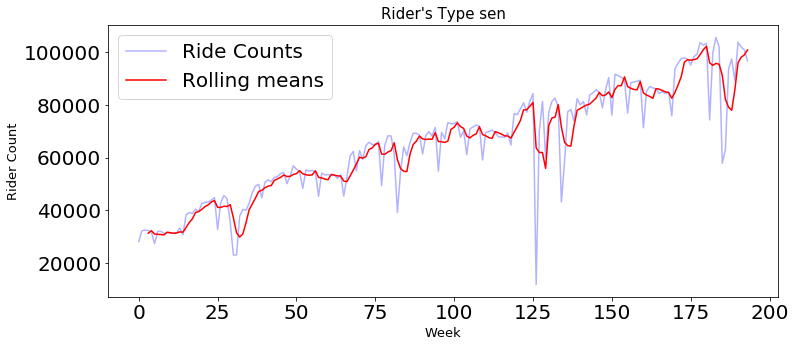

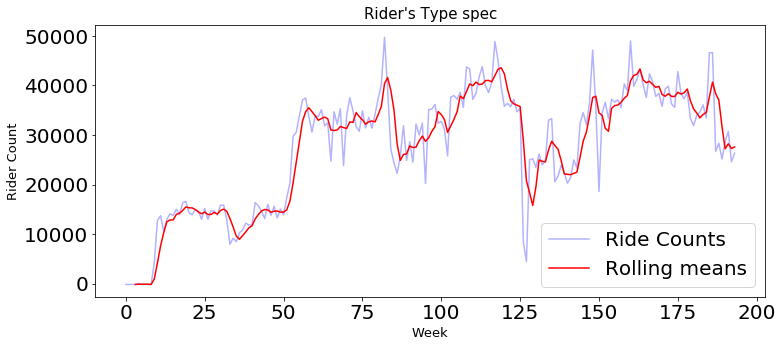

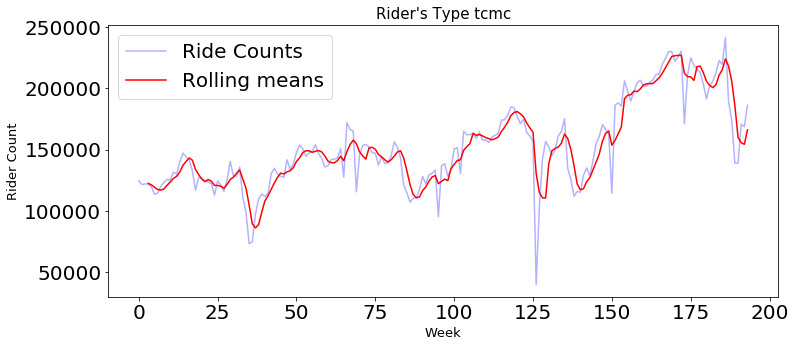

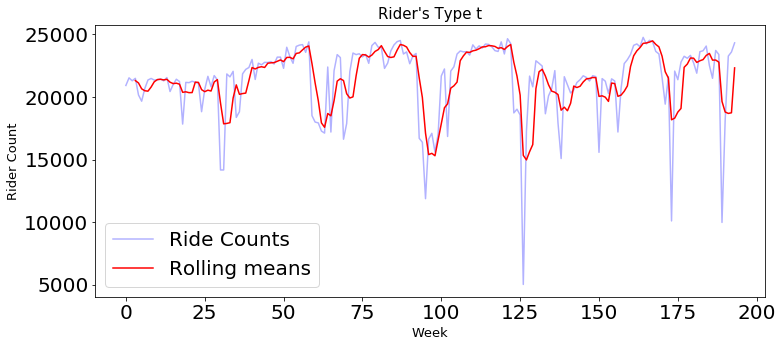

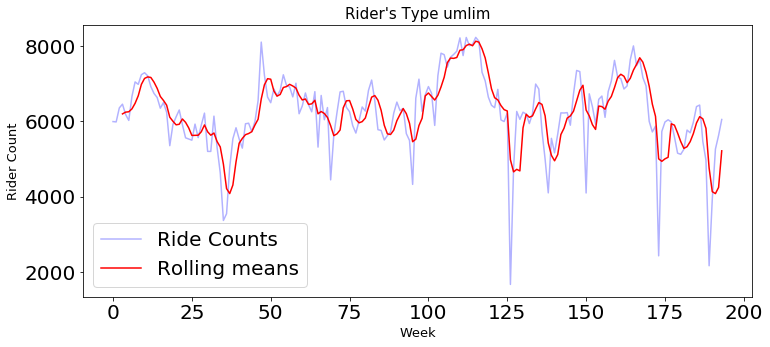

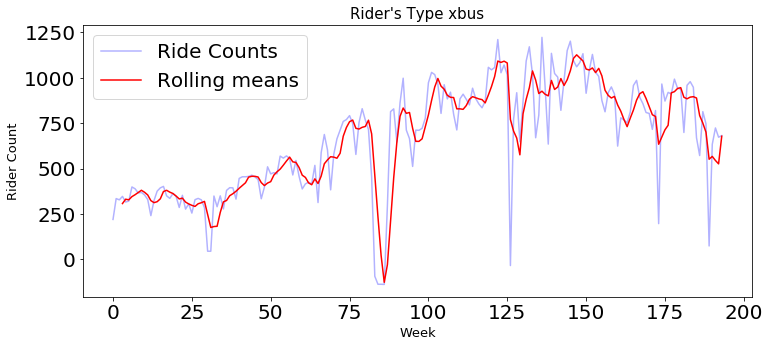

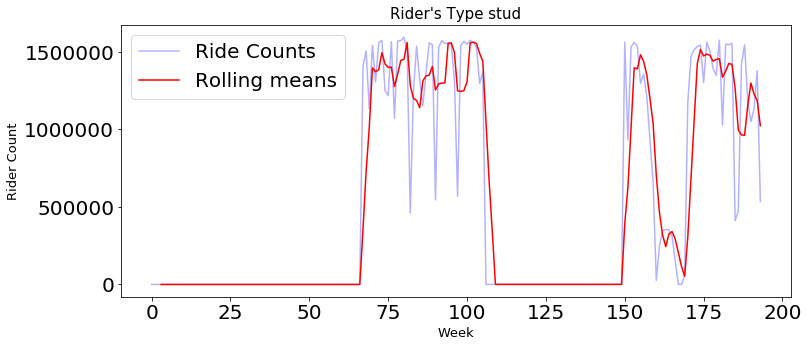

In [21]:
#for i in range ((len(ridetype_dft.columns))):

#pl.figure(figsize=(10,7))
# Plotting all ridetypes, 4 week window representing the rolling mean monthly. 
for i in ridetype_dft.columns:
    pl.figure(figsize=(12,5))
    #roll_mean =pd.rolling_mean(np.log10(ridetype_dft[i]), window=4)
    # np.log10 won't generate result for -1 so using the original count for y axis
    roll_mean =pd.rolling_mean(ridetype_dft[i], window=4)
    pl.plot(ridetype_dft.index, ridetype_dft[i], c='b', label="Ride Counts",alpha=0.3)
    pl.plot(ridetype_dft.index, roll_mean, c='r', label="Rolling means")
    pl.title("Rider's Type {}".format(i), fontsize=15)
    pl.ylabel("Rider Count", fontsize=13)
    pl.xlabel("Week", fontsize=13)
    pl.legend()

## Interpretation of Figure 5 Observation:
Ridetype 14d (2 weeks), 7d (one week), month (one month or 4 weeks), rr (roll road), sen (senior citizens), tcmc, demonstrate relatively smooth changes with visible trend. 
Ridetype 1d (one day), mc, rfm, spec, and xbus demonstrate non-smooth changes with visible trends
Ridetype 10t (10 trips), 2t (2 trips), 30d (30 days), ada (american with diabilities act), t(1 trip), unlim (unlimited pass) show fluctuations but no obvious trend. 
Ridetype afas, exp, ez, ff, mr, stud demonstrate data gaps so it's hard to describe the trends. 

In [22]:
# Changes between the first 10 weeks and the last 10 weeks. 
ridetype_df_10a=ridetype_df.iloc[:, 0:10]
ridetype_df_10z=ridetype_df.iloc[:, 184:194]

In [23]:
ridetype_df_10a['mean'] = ridetype_df_10a.mean(axis=1)
ridetype_df_10z['mean'] = ridetype_df_10z.mean(axis=1)
ridetype_df_10a_mean = ridetype_df_10a[['mean']]
ridetype_df_10z_mean = ridetype_df_10z[['mean']]
ridetype_compare = pd.merge(ridetype_df_10a_mean, ridetype_df_10z_mean, left_index=True, right_index=True)
ridetype_compare.columns = ['First 10 Weeks', 'Last 10 Weeks']
ridetype_compare['Difference'] = ridetype_compare['First 10 Weeks'] - ridetype_compare['Last 10 Weeks']
ridetype_compare['Ratio of Change'] = ridetype_compare['Difference'] / ridetype_compare['First 10 Weeks']
ridetype_compare = ridetype_compare.sort_values(by=['Ratio of Change'])
ridetype_compare

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


First 10 Weeks  Last 10 Weeks  Difference  Ratio of Change
spec            316.8        31725.0    -31408.2       -99.142045
sen           31071.4        90660.4    -59589.0        -1.917809
rr            64378.8       167149.6   -102770.8        -1.596345
xbus            339.0          653.8      -314.8        -0.928614
tcmc         120723.4       185053.4    -64330.0        -0.532871
7d          3934166.4      5467551.2  -1533384.8        -0.389761
14d          533239.0       667683.9   -134444.9        -0.252129
mc           131752.5       159915.7    -28163.2        -0.213758
1d            49761.7        55317.1     -5555.4        -0.111640
30d           47819.0        49438.7     -1619.7        -0.033871
10t        12347188.9     12616334.4   -269145.5        -0.021798
t             20993.9        21449.5      -455.6        -0.021702
2t           190490.3       177870.8     12619.5         0.066247
ada         9117434.0      8204229.7    913204.3         0.100160
ff            41117.7        33641.8      7475.9         0.181817
umlim          6489.1         5223.3      1265.8         0.195066
rfm          843891.1       548150.1    295741.0         0.350449
month        137159.2        79318.7     57840.5         0.421703
ez           599081.5         -136.9    599218.4         1.000229
exp          327362.5         -134.3    327496.8         1.000410
afas          10844.1         -135.5     10979.6         1.012495
mr             -131.4       143614.8   -143746.2      1093.958904
stud           -600.0      1068401.8  -1069001.8      1781.669667

## Interpretations:
Based on the above table, we can see that student rides has the most significant change and 1 trip rides has the least changes. The dramatic increase of student rides can be due to the implementation of students' tickets. 1 trip rides are very general and many people might use the subway with one ride fare. 

# 3. Build  models that classified the *ride type* based on the time series characteristics using random forests. 

Clean the data from missing values (drop time series with NaNs)

Use all the time series, and use the ticket type as a label (remember that the original data is sorted by ticket type in axis=1).

Calculate the mean, standard deviation for each time series and by station and create the features as instructed below

Split the training and test data (66%/33%)

Build and test a random forest model that predicts the ticket type based on 4 engineered features (see below).

Build and test a random forest model that predicts the ticket type based on all datapoint in the time series (194 features)

Plot a confusion matrix for each model (discuss)

Compare the models using sklearn.metrics classification_report

Find the 2 most important features in each model 



## Build one that uses as input features the following engineered features :
- the time series mean divided by the mean of all time series for that station
- the time series standard deviation by the  standard deviation of all time series for that station
- the slope and intercept of a line fit to the standardized time series 
        (time_series - time_series.mean())/time_series.std()
        

In [24]:
# Drop nan
ridetype_dft = ridetype_dft.dropna()
mta = mta.astype(float)

In [25]:
mta[mta==-1] = np.nan

In [26]:
mta_cl = mta[~numpy.isnan(mta)]

In [27]:
mta_cl.shape

(2027637,)

In [28]:
# Using the already reshaped array
Rides_n.shape

(13800, 194)

In [29]:
stationid = np.concatenate([np.array([i] * 23) for i in range(600)])
stationid[Rides_n.std(1) > 0]

array([  0,   0,   0, ..., 550, 550, 550])

In [30]:
# Finding the time series mean for each station.
# mta array has the length of 600 which each series represents a station with 23 types within 194 weeks.
station_mean = []
for i in range (len(mta)):
    st_mean = np.nanmean(mta[i])
    station_mean.append(st_mean)
len(station_mean)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python2/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


600

In [31]:
# Coverting the list to numpy array
station_mean = np.array(station_mean)
station_mean.shape

(600,)

In [32]:
# Finding the time series std for each station.
station_std = []
for i in range (len(mta)):
    st_std = np.nanstd(mta[i])
    station_std.append(st_std)
len(station_std)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python2/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:1147: RuntimeWarning: Degrees of freedom <= 0 for slice.
  warnings.warn("Degrees of freedom <= 0 for slice.", RuntimeWarning)


600

In [33]:
# Coverting the list to numpy array
station_std = np.array(station_std)
station_std.shape

(600,)

In [34]:
Rides_df_st = np.nansum(mta,axis=1)

In [35]:
Rides_nan = Rides_pd.replace(-23, np.nan)

In [36]:
Rides_cl = Rides_nan.dropna().reset_index()
Rides_cl = Rides_cl.drop(['index'],axis=1)

In [37]:
Rides_cl['Station_Mean'] = Rides_cl.mean(axis=1).astype(float)
Rides_cl['Station_Std'] = Rides_cl.std(axis=1).astype(float)
Rides_cl.head(9)

0         1         2         3         4         5         6  \
0    6605.0    6880.0    7228.0    5730.0    7031.0    5106.0    5496.0   
1   16377.0   17407.0   17594.0   14241.0   17588.0   13167.0   14509.0   
2   18563.0   19902.0   19947.0   16075.0   20282.0   14600.0   16150.0   
3   19986.0   20624.0   21224.0   17411.0   20908.0   15588.0   17186.0   
4   12448.0   13643.0   13718.0   11459.0   14093.0   10294.0   11503.0   
5   11090.0   11658.0   12036.0    9808.0   11943.0    8585.0    9773.0   
6   10481.0   11029.0   10880.0    9122.0   10922.0    8016.0    8962.0   
7  147186.0  154825.0  155957.0  154913.0  157627.0  150258.0  155081.0   
8  325121.0  353884.0  351749.0  349922.0  349820.0  327753.0  355681.0   

          7         8         9      ...            186       187       188  \
0    5667.0    5554.0    6941.0      ...         5656.0    7665.0    8377.0   
1   14387.0   14220.0   17179.0      ...        15586.0   21806.0   23534.0   
2   16065.0   16204.0   19618.0      ...        17293.0   21484.0   22516.0   
3   16896.0   16951.0   20562.0      ...        18728.0   23467.0   25139.0   
4   11518.0   11448.0   13545.0      ...        11261.0   14805.0   15340.0   
5    9650.0    9820.0   11567.0      ...         9813.0   14256.0   14931.0   
6    8628.0    8843.0   10577.0      ...         9817.0   12189.0   12779.0   
7  156878.0  155848.0  157009.0      ...       229768.0  195337.0  194003.0   
8  355458.0  354670.0  354134.0      ...       312630.0  396637.0  375903.0   

        189       190       191       192       193   Station_Mean  \
0    7343.0    7743.0    8171.0    7907.0    6790.0    7243.793814   
1   20604.0   21370.0   22459.0   22773.0   19033.0   19017.288660   
2   20560.0   21942.0   23283.0   22987.0   21562.0   20371.221649   
3   22793.0   24354.0   25818.0   25499.0   23341.0   22270.329897   
4   14107.0   15079.0   15602.0   15361.0   14211.0   13857.216495   
5   13268.0   13539.0   15251.0   15259.0   12294.0   12893.726804   
6   11714.0   12594.0   13188.0   13089.0   12489.0   11319.453608   
7  190393.0  203532.0  205508.0  193804.0  207511.0  191203.030928   
8  361649.0  396143.0  380779.0  370034.0  375330.0  356733.077320   

    Station_Std  
0    979.610789  
1   3155.888250  
2   2445.322351  
3   2797.998829  
4   1616.037229  
5   2082.972030  
6   1401.372711  
7  26731.276960  
8  32237.729809  

[9 rows x 196 columns]

In [39]:
# Normalization
# TS mean/Station mean
# TS std/Station std
# In this one, TS mean is interpreted as mean one time stamp
mean_norm_t = []
std_norm_t = []
for i in range(mta.shape[0]):
    for j in range(mta.shape[1]):
        std = np.nanstd(Rides_n[j])/Rides_n[i]
        mean = np.nanmean(Rides_n[j])/Rides_n[i]
        std_norm_t.append(std)
        mean_norm_t.append(mean)
std_norm_t = np.asarray(std_norm_t)
mean_norm_t = np.asarray(mean_norm_t)
mean_norm_t[0:10], std_norm_t[0:10]

(array([[  1.01794011e+00,   8.96139075e-01,   8.52664430e-01, ...,
           1.58739800e+00,   1.70894770e+00,   1.57459501e+00],
        [  3.17642728e-02,   2.79635371e-02,   2.66069342e-02, ...,
           4.95338994e-02,   5.33267925e-02,   4.91343890e-02],
        [  4.12327697e-03,   3.62990865e-03,   3.45380988e-03, ...,
           6.42992798e-03,   6.92227827e-03,   6.37806809e-03],
        ..., 
        [  1.48772437e-04,   1.30971158e-04,   1.24617317e-04, ...,
           2.31998982e-04,   2.49763530e-04,   2.30127819e-04],
        [  1.69780662e-02,   1.49465655e-02,   1.42214586e-02, ...,
           2.64759665e-02,   2.85032753e-02,   2.62624275e-02],
        [  7.49328035e-03,   6.59667623e-03,   6.27664984e-03, ...,
           1.16851847e-02,   1.25799388e-02,   1.15909391e-02]]),
 array([[  3.27136349e-01,   2.87993038e-01,   2.74021552e-01, ...,
           5.10143553e-01,   5.49206094e-01,   5.06029045e-01],
        [  9.49531837e-03,   8.35916155e-03,   7.95363121e-0

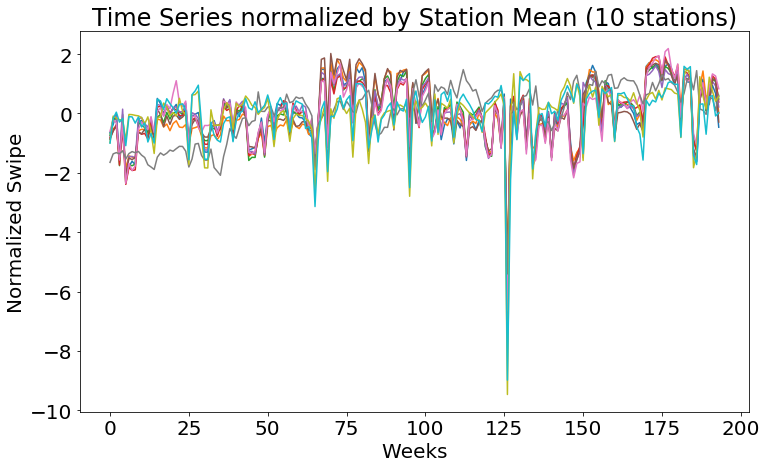

In [40]:
pl.figure(figsize=(12,7))
for i in range (10):
    pl.plot(Rides_cl.columns[0:194], (Rides_cl.loc[i][0:194] - Rides_cl['Station_Mean'][i])/Rides_cl['Station_Std'][i])
pl.title('Time Series normalized by Station Mean (10 stations)')
pl.xlabel('Weeks')
pl.ylabel('Normalized Swipe')

## Caption:
We can see that, after normalized by station mean, the time trend of each station are getting closer.

In [43]:
tot = mta.reshape(13800,194)
tot_pd = pd.DataFrame(tot)
tot_pd.head()

0        1        2        3        4        5        6        7    \
0  56961.0  64703.0  68002.0  72628.0  75866.0  72433.0  71186.0  71498.0   
1   1732.0   2083.0   2107.0   2188.0   2314.0   1921.0   2072.0   1999.0   
2    203.0    276.0    245.0    280.0    265.0    241.0    278.0    236.0   
3    883.0    958.0    976.0    987.0   1012.0    927.0    898.0    902.0   
4    358.0    529.0    422.0    261.0    248.0    362.0    479.0    345.0   

       8        9     ...         184      185      186      187      188  \
0  73801.0  72517.0   ...     43608.0  44774.0  46955.0  39050.0  37384.0   
1   2031.0   1980.0   ...      1425.0   1085.0    965.0   1284.0   1407.0   
2    258.0    264.0   ...       217.0    189.0    150.0    194.0    183.0   
3    907.0    907.0   ...       576.0    460.0    388.0    517.0    593.0   
4    192.0    414.0   ...       290.0    109.0    124.0    349.0    357.0   

       189      190      191      192      193  
0  33864.0  38358.0  36527.0  33929.0  36824.0  
1   1085.0   1389.0   1264.0   1172.0   1238.0  
2    185.0    200.0    186.0    167.0    167.0  
3    498.0    538.0    545.0    516.0    489.0  
4    197.0    220.0    281.0    309.0    245.0  

[5 rows x 194 columns]

In [44]:
ts_mean=np.nanmean(tot,axis=1)
ts_std=np.nanstd(tot,axis=1)
ts_mean.shape, ts_std.shape

((13800,), (13800,))

In [45]:
ts_mean[0:10], ts_std[0:10]

(array([  5.85868854e+04,   1.82818229e+03,   2.37322917e+02,
          7.37656250e+02,   2.93140625e+02,   2.00333073e+04,
          3.05572969e+04,   8.57291667e+00,   9.77171875e+02,
          4.31281250e+02]),
 array([ 17761.09203889,    510.96567389,     66.53171155,    187.21263135,
           140.82415903,   5934.29867244,  10025.54800094,     18.7351301 ,
          2314.85723026,    991.81311982]))

(-5, 5)

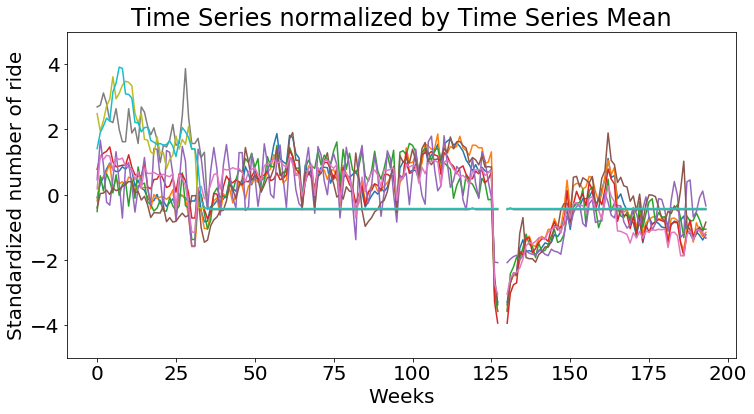

In [46]:
# (time_series - time_series.mean())/time_series.std()
swipe_normts  = []
for i in range(len(tot_pd)):
    y = (tot_pd.loc[i] - ts_mean[i]) / ts_std[i]
    swipe_normts.append(y)
# swipe_normts[1]
pl.figure(figsize=(12,6))
for i in range(10):
    pl.plot(range(194), swipe_normts[i])
pl.title('Time Series normalized by Time Series Mean')
pl.xlabel("Weeks")
pl.ylabel("Standardized number of ride")
pl.ylim(-5,5)

## Caption:
After normalized the value by time series mean, the trend of each ticket type at the same station is still distinguishable. 

In [47]:
# Adding ride type and station number into the complete dataset
# https://stackoverflow.com/questions/21068971/how-to-fill-in-rows-with-repeating-data-in-pandas
labels = cycle(np.arange(0,23,1))
sta = np.arange(0,600,1)
station = np.repeat(sta, 23)
tot_pd['Type'] = [next(labels) for count in range(tot_pd.shape[0])]
tot_pd['Station'] = station
tot_pd['station_mean'] = np.repeat(station_mean,23)
tot_pd['station_std'] = np.repeat(station_std,23)
tot_pd.head()

0        1        2        3        4        5        6        7  \
0  56961.0  64703.0  68002.0  72628.0  75866.0  72433.0  71186.0  71498.0   
1   1732.0   2083.0   2107.0   2188.0   2314.0   1921.0   2072.0   1999.0   
2    203.0    276.0    245.0    280.0    265.0    241.0    278.0    236.0   
3    883.0    958.0    976.0    987.0   1012.0    927.0    898.0    902.0   
4    358.0    529.0    422.0    261.0    248.0    362.0    479.0    345.0   

         8        9      ...           188      189      190      191  \
0  73801.0  72517.0      ...       37384.0  33864.0  38358.0  36527.0   
1   2031.0   1980.0      ...        1407.0   1085.0   1389.0   1264.0   
2    258.0    264.0      ...         183.0    185.0    200.0    186.0   
3    907.0    907.0      ...         593.0    498.0    538.0    545.0   
4    192.0    414.0      ...         357.0    197.0    220.0    281.0   

       192      193  Type  Station  station_mean   station_std  
0  33929.0  36824.0     0        0   5325.340998  14254.240936  
1   1172.0   1238.0     1        0   5325.340998  14254.240936  
2    167.0    167.0     2        0   5325.340998  14254.240936  
3    516.0    489.0     3        0   5325.340998  14254.240936  
4    309.0    245.0     4        0   5325.340998  14254.240936  

[5 rows x 198 columns]

In [48]:
# Dropping nan in this dataset
tot_pd = tot_pd.dropna()
# After dropping, storing the ridetypes and stations which has valid numbers
labels_com = tot_pd['Type']
station_com = tot_pd['Station']
stat_mean = tot_pd['station_mean']
stat_std = tot_pd['station_std']

In [49]:
# Drop them now to calculate the mean
tot_mod = tot_pd.drop(['Type', 'Station', 'station_mean', 'station_std'], axis=1)

In [50]:
# Create the time series mean and std in this table
tot_mod['Mean'] = tot_mod.mean(axis=1)
tot_mod['Std'] = tot_mod.std(axis=1)

In [51]:
# Store the mean and std then drop them 
# We don't want the model to count other values but only the time series values for the fitting model
mean_mod = tot_mod['Mean']
std_mod = tot_mod['Std']
tot_mod = tot_mod.drop(['Mean','Std'], axis=1)

In [52]:
# Normalization, take a mean from every 23 rows
# TS mean/Station mean
# TS std/Station std
# https://stackoverflow.com/questions/36810595/calculate-average-of-every-x-rows-in-a-table-and-create-new-table/36810658

#normed_time_series_meannormed = [] 
#normed_time_series_stdnorded = []
#for i in range(600):
 #   mean = (tot_pd.groupby(np.arange(len(tot_pd))//23).mean())/station_mean[i]
  #  std = (tot_pd.groupby(np.arange(len(tot_pd))//23).std())/station_std[i]
   # normed_time_series_meannormed.append(mean)
   # normed_time_series_stdnorded.append(std)
#len(normed_time_series_meannormed), len(normed_time_series_stdnorded)

In [53]:
# To have intercepts, we need to add constant here
# https://stackoverflow.com/questions/20701484/why-do-i-get-only-one-parameter-from-a-statsmodels-ols-fit
week = range(194)
week = sm.add_constant(week)

In [54]:
# Modeling
S={}
I={}
Slope=[]
Intercept=[]
for i in range(len(tot_mod)):
    S[i] = sm.OLS(tot_mod.iloc[i], week).fit().params[0]
    I[i] = sm.OLS(tot_mod.iloc[i], week).fit().params[1]
    Slope.append(S[i])
    Intercept.append(I[i])

In [55]:
# Adding Slope and intercepts back to the table 
tot_mod['Slope'] = Slope
tot_mod['Intercept'] = Intercept
tot_mod.head()

0       1       2       3       4       5       6       7       8  \
46  3292.0  3429.0  3629.0  2808.0  3614.0  2601.0  2848.0  2798.0  2888.0   
47   110.0    92.0   102.0    79.0    93.0    74.0    72.0    92.0    97.0   
48     7.0     6.0    13.0     7.0     5.0     7.0     7.0     6.0     3.0   
49    41.0    51.0    47.0    37.0    50.0    43.0    44.0    32.0    43.0   
50     0.0     0.0     0.0     0.0     1.0     1.0     0.0     0.0     0.0   

         9    ...         186     187     188     189     190     191     192  \
46  3591.0    ...      2679.0  3337.0  3599.0  3273.0  3418.0  3746.0  3406.0   
47    95.0    ...       160.0   180.0   204.0   166.0   191.0   212.0   209.0   
48     4.0    ...        18.0    20.0    19.0    13.0    19.0    26.0    20.0   
49    57.0    ...        24.0    20.0    25.0    29.0    31.0    28.0    24.0   
50     2.0    ...         1.0    10.0     8.0     6.0     5.0     5.0     6.0   

       193        Slope  Intercept  
46  3217.0  3545.231879   0.038193  
47   211.0    81.160349   0.657278  
48    22.0     9.239017   0.090146  
49    22.0    40.726566  -0.108485  
50     0.0    -1.437431   0.044915  

[5 rows x 196 columns]

In [56]:
# Adding ridetypes, stations, means, and stds back to the table for the random forest building. 
tot_mod['Ridetype'] = labels_com
tot_mod['Station'] = station_com
tot_mod['Mean'] = mean_mod
tot_mod['Std'] = std_mod
tot_mod['station_mean'] = stat_mean
tot_mod['station_std'] = stat_std
tot_mod['Mean_norm'] = tot_mod['Mean']/tot_mod['station_mean']
tot_mod['Std_norm'] = tot_mod['Std']/tot_mod['station_std']
tot_mod.head()

0       1       2       3       4       5       6       7       8  \
46  3292.0  3429.0  3629.0  2808.0  3614.0  2601.0  2848.0  2798.0  2888.0   
47   110.0    92.0   102.0    79.0    93.0    74.0    72.0    92.0    97.0   
48     7.0     6.0    13.0     7.0     5.0     7.0     7.0     6.0     3.0   
49    41.0    51.0    47.0    37.0    50.0    43.0    44.0    32.0    43.0   
50     0.0     0.0     0.0     0.0     1.0     1.0     0.0     0.0     0.0   

         9    ...           Slope  Intercept  Ridetype  Station         Mean  \
46  3591.0    ...     3545.231879   0.038193         0        2  3548.917526   
47    95.0    ...       81.160349   0.657278         1        2   144.587629   
48     4.0    ...        9.239017   0.090146         2        2    17.938144   
49    57.0    ...       40.726566  -0.108485         3        2    30.257732   
50     2.0    ...       -1.437431   0.044915         4        2     2.896907   

           Std  station_mean  station_std  Mean_norm  Std_norm  
46  391.400424     319.76405    825.23524  11.098551  0.474290  
47   43.600755     319.76405    825.23524   0.452170  0.052834  
48    8.137117     319.76405    825.23524   0.056098  0.009860  
49    9.809819     319.76405    825.23524   0.094625  0.011887  
50    4.235307     319.76405    825.23524   0.009060  0.005132  

[5 rows x 204 columns]

In [57]:
#tot_pd_notype = tot_pd.drop(['Type'], axis=1)

In [58]:
#array_tot = np.array(tot_pd_notype)
#array_tot.shape

you will have to remove time series containing NaN because the random forest sklearn implementation does not work with NaNs. 
An easy way to do that is to remove all time series whose standard deviation is NaN
Here is how you would use to only extract station id for the valid (no containing nan) time series


You can use the sklearn train_test_split() function to create your training and test dataset. 

In [88]:
# Using the sklean to make training and test dataset
X_train, X_test, y_train, y_test = train_test_split(
    np.array([tot_mod['Slope'], tot_mod['Intercept'], 
              tot_mod['Mean_norm'], tot_mod['Std_norm']]).T, tot_mod['Ridetype'], 
    test_size=0.33, random_state=42, shuffle=True)

In [89]:
np.array(X_train).shape, np.array(X_test).shape, np.array(y_train).shape, np.array(y_test).shape

((6146, 4), (3028, 4), (6146,), (3028,))

depending on the details of your data processing you may have infinities as well. You also will have to get read of them

In [90]:
#(~np.isfinite(X_train)).sum(),(~np.isfinite(X_test)).sum(),(~np.isfinite(y_train)).sum(),(~np.isfinite(y_test)).sum()

In [91]:
clf = rfc(n_estimators=10, criterion='gini', 
             max_depth=None, min_samples_split=2, 
             min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', 
             max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, 
             bootstrap=True, oob_score=False, n_jobs=1, random_state=None, verbose=0, 
             warm_start=False, class_weight=None)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [92]:
y_pred = clf.predict(X_test)

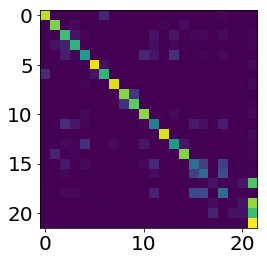

In [93]:
imshow(confusion_matrix(y_test, y_pred))

and use sklearn confusion_matrix to see the errors

 and use classification_report to assess the model and clf.feature_importances_ to find the important features

In [94]:
print(classification_report(y_test, y_pred, target_names=ridetype))

             precision    recall  f1-score   support

        10t       0.88      0.88      0.88       151
        14d       0.84      0.88      0.86       134
         1d       0.61      0.73      0.67       139
         2t       0.76      0.76      0.76       126
        30d       0.70      0.57      0.63       146
         7d       0.94      0.93      0.93       154
        ada       0.81      0.79      0.80       123
       afas       0.97      0.95      0.96       146
        exp       0.86      0.82      0.84       147
         ez       0.82      0.83      0.82       134
         ff       0.80      0.89      0.84       137
         mc       0.53      0.50      0.51       123
         mr       0.99      0.98      0.98       142
      month       0.68      0.62      0.65       130
        rfm       0.89      0.86      0.87       140
         rr       0.41      0.36      0.38       146
        sen       0.41      0.42      0.41       125
       spec       0.25      0.06      0.09   

## Build a model that uses as input features each time stamp (194 features) :


In [95]:
# use the same split ratio
# Getting rid of all the other calculated values or assigned values first then use time series vs ticket type
tot_a = tot_mod.drop(['Slope','Intercept','Ridetype', 'Station', 'Mean','Std','station_mean','station_std',
                       'Mean_norm','Std_norm','Ridetype'],axis=1)
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(tot_a, 
                                                    tot_mod['Ridetype'], test_size=0.33, random_state=42, shuffle=True)

In [96]:
np.array(X_train_1).shape, np.array(X_test_1).shape, np.array(y_train_1).shape, np.array(y_test_1).shape

((6146, 194), (3028, 194), (6146,), (3028,))

In [97]:
clf1 = rfc(n_estimators=10, criterion='gini', 
             max_depth=None, min_samples_split=2, 
             min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', 
             max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, 
             bootstrap=True, oob_score=False, n_jobs=1, random_state=None, verbose=0, 
             warm_start=False, class_weight=None)
clf1.fit(X_train_1, y_train_1)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [98]:
y_pred_1 = clf1.predict(X_test_1)

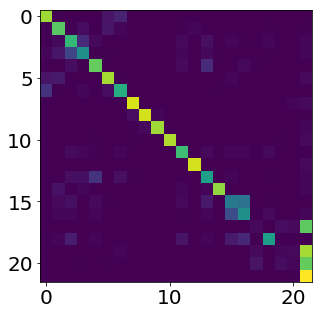

In [103]:
pl.figure(figsize=(5,5))
imshow(confusion_matrix(y_test_1, y_pred_1))

## Caption:
On the diaganol, each ticket type is scored against itself and demonstrates a stronger correlation. Xbus ticket series demonstrate stronger correlation with unlimited pass, regular ticket, and special ticket. 


In [100]:
print(classification_report(y_test_1, y_pred_1, target_names=ridetype))

             precision    recall  f1-score   support

        10t       0.80      0.85      0.82       151
        14d       0.74      0.83      0.78       134
         1d       0.60      0.71      0.65       139
         2t       0.67      0.59      0.62       126
        30d       0.77      0.78      0.77       146
         7d       0.84      0.84      0.84       154
        ada       0.78      0.76      0.77       123
       afas       0.95      0.96      0.95       146
        exp       0.98      0.95      0.96       147
         ez       0.98      0.96      0.97       134
         ff       1.00      0.96      0.98       137
         mc       0.81      0.84      0.82       123
         mr       0.99      0.98      0.98       142
      month       0.65      0.65      0.65       130
        rfm       0.98      0.89      0.93       140
         rr       0.52      0.41      0.46       146
        sen       0.48      0.59      0.53       125
       spec       0.24      0.03      0.06   

## Interpretation:
The precision demonstrates that ticket type valid length does not seem to make swiping frequency easier to predict. In this case, unlimited pass is almost the hardest to predict.